In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import dicom as dicom
import os
import glob
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from sklearn.preprocessing import LabelEncoder
#from mpl.toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib inline
print('Hello')

Hello


In [2]:
# Download DICOM images
data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)
labels_brca = pd.read_csv('D:\Insight\clin.txt',sep='\t',#names=['patients','class'],
                          #index_col=0,
                          na_values='NA',
                          usecols=['patient.bcr_patient_barcode','class','patient.stage_event.pathologic_stage'] )
patients.sort()
#print patients
labels_brca.rename(index=str, columns={"patient.bcr_patient_barcode": "patients",
                                      'patient.stage_event.pathologic_stage': 'class2'}, inplace=True)
labels_brca['patients'] = labels_brca['patients'].str.upper()
print(len(patients), len(labels_brca))
print(labels_brca.head())

139 1097
       patients     class2  class
0  TCGA-5L-AAT0  stage iia  early
1  TCGA-5L-AAT1   stage iv   late
2  TCGA-A1-A0SP  stage iia  early
3  TCGA-A2-A04V  stage iia  early
4  TCGA-A2-A04Y  stage iib  early


In [27]:
#print(labels_brca.iloc[5:10,"class2"])
#print(labels_brca["class2"].head())
#print(np.unique(labels_brca["class2"]))

In [3]:
# Label Encoder
encoder = LabelEncoder()
encoder.fit(labels_brca["class"])
labels_brca['y'] = encoder.transform(labels_brca["class"])
print (labels_brca.iloc[:,1:4].head())
#print labels_brca['y'].head()

      class2  class  y
0  stage iia  early  0
1   stage iv   late  1
2  stage iia  early  0
3  stage iia  early  0
4  stage iib  early  0


In [267]:
# Resolving path to dcm files

data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)

#print data_dir
#print patients[1]
path1 = data_dir + '/' + patients[0]
files1 = os.listdir(path1)
#print path1
path2 = path1 +  '/' + files1[0]
files2 = os.listdir(path2)
#print path2[0]
path3 = path2 +  '/' + files2[0]
files3 = os.listdir(path3)
#print path3
path4 = path3 + '/' + files3[0]
#print (path4)
#test =[dicom.read_file(path3 + '/' + s) for s in os.listdir(path3)]
#print test[0].Modality

C:\TCIA-BRCA\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.105050108785380600324694049408/000000.dcm


In [4]:
# splitting patients into train and validation sets
data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)
patients = list(set(patients))
patients.sort()
#print(labels_brca.head())
patient_labels = []
for patient in patients:
    label = int(labels_brca['y'][labels_brca['patients']==patient].values)
    patient_labels.append(label)

print(patients[:10])
print(patient_labels[:10])

['TCGA-AO-A03M', 'TCGA-AO-A03V', 'TCGA-AO-A0J8', 'TCGA-AO-A0J9', 'TCGA-AO-A0JB', 'TCGA-AO-A0JF', 'TCGA-AO-A0JI', 'TCGA-AO-A0JM', 'TCGA-AO-A129', 'TCGA-AO-A12D']
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [8]:
# split into train and test
from sklearn.model_selection import train_test_split

X, y = patients, patient_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=54)

print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

97 97
42 42


In [10]:
from collections import Counter
print(Counter(patient_labels))
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 131, 1: 8})
Counter({0: 92, 1: 5})
Counter({0: 39, 1: 3})


In [313]:
scan_paths= []
for patient in os.listdir(data_dir):
    path1 = data_dir + '/' + patient
    for y in os.listdir(path1):
        path2 = path1 + '/' + y
        for scan in os.listdir(path2):
            scan_paths.append(path2 + '/' + scan)
scan_paths.sort()
print(len(scan_paths))

1877


In [315]:
#print(scan_paths[:10])

In [296]:
data_dir = 'C:\TCIA-BRCA\DOI'
scans= []
Modality = []
patient_id=[]
views = []
labels = []

for patient in os.listdir(data_dir)[:3]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path1 = data_dir + '/' + patient
    for y in os.listdir(path1):
        path2 = path1 + '/' + y
        for z in os.listdir(path2)[:2]:
            path3 = path2 + '/' + z
            scans = [dicom.read_file(path3 + '/' + s) for s in os.listdir(path3)
                    if (dicom.read_file(path3+'/'+ s)).Modality =='MR'
                    if len(os.listdir(path3))>=20
                    ]
            scans.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            #print(len(scans),scans[0].pixel_array.shape, scans[0].CodeMeaning,scans[0].PatientID,scans[0].Modality)
            #views.append(scans[0].ProtocolName)
            if scans:
                patient_id.append(scans[0].PatientID)
                Modality.append(scans[0].Modality)
                labels.append(label)
#           for dcm in os.listdir(path3):
#           print (path3 + '/' + dcm)
print (len(scans))
print(patient_id[:5])
#print(views[:5])
print(Modality[:5])

100
['TCGA-AO-A03M', 'TCGA-AO-A03V', 'TCGA-AO-A03V', 'TCGA-AO-A0J8', 'TCGA-AO-A0J8']
['MR', 'MR', 'MR', 'MR', 'MR']


In [12]:
data_dir = 'C:\TCIA-BRCA\DOI'
#scans= []
Modality = []
patient_id=[]
views = []
labels = []
pos_scans = []
IMG_PX_SIZE = 150

for patient in os.listdir(data_dir):
    #label = labels_brca['y'][labels_brca['patients']==patient].values
    path1 = data_dir + '/' + patient
    #print(patient, label)
    for y in os.listdir(path1):
        path2 = path1 + '/' + y
        for z in os.listdir(path2)[:2]:
            path3 = path2 + '/' + z
            scans = [dicom.read_file(path3 + '/' + s) for s in os.listdir(path3)
                    #if (dicom.read_file(path3+'/'+ s)).Modality =='MR'
                    #if len(os.listdir(path3))>=20
                    ]
            #scans.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            #print(len(scans),scans[0].pixel_array.shape, scans[0].CodeMeaning,scans[0].PatientID,scans[0].Modality)
            #views.append(scans[0].ProtocolName)
            patient_id.append(scans[0].PatientID)
            patient = scans[0].PatientID
            label = labels_brca['y'][labels_brca['patients']==patient].values
            Modality.append(scans[0].Modality)
            labels.append(label)
            #scans.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            #scans = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in scans]
            if label==1:
                pos_scans.append([scans])
#           for dcm in os.listdir(path3):
#           print (path3 + '/' + dcm)
print (len(scans))
print(len(patient_id))
#print(views[:5])
print(len(Modality))
print(len(pos_scans))

TCGA-AO-A03M [0]
TCGA-AO-A03V [0]
TCGA-AO-A0J8 [0]
TCGA-AO-A0J9 [1]
TCGA-AO-A0JB [0]
TCGA-AO-A0JF [0]
TCGA-AO-A0JI [0]
TCGA-AO-A0JM [0]
TCGA-AO-A129 [0]
TCGA-AO-A12D [0]
TCGA-AO-A12E [0]
TCGA-AO-A12F [0]
TCGA-AO-A12G [0]
TCGA-AQ-A04H [0]
TCGA-AR-A1AN [0]
TCGA-AR-A1AQ [0]
TCGA-AR-A1AX [0]
TCGA-AR-A24M [0]
TCGA-AR-A24R [0]
TCGA-AR-A24S [0]
TCGA-AR-A24U [0]
TCGA-AR-A24W [0]
TCGA-AR-A24X [0]
TCGA-AR-A254 [0]
TCGA-BH-A0AW [0]
TCGA-BH-A0AZ [0]
TCGA-BH-A0B1 [0]
TCGA-BH-A0B3 [0]
TCGA-BH-A0B5 [0]
TCGA-BH-A0B6 [0]
TCGA-BH-A0BG [0]
TCGA-BH-A0BJ [0]
TCGA-BH-A0BM [0]
TCGA-BH-A0BQ [0]
TCGA-BH-A0BT [0]
TCGA-BH-A0C0 [0]
TCGA-BH-A0DE [0]
TCGA-BH-A0DG [0]
TCGA-BH-A0DH [0]
TCGA-BH-A0DI [0]
TCGA-BH-A0DK [0]
TCGA-BH-A0DT [0]
TCGA-BH-A0DV [0]
TCGA-BH-A0DX [0]
TCGA-BH-A0DZ [0]
TCGA-BH-A0E0 [1]
TCGA-BH-A0E1 [0]
TCGA-BH-A0E2 [0]
TCGA-BH-A0E9 [0]
TCGA-BH-A0EI [0]
TCGA-BH-A0GY [0]
TCGA-BH-A0GZ [0]
TCGA-BH-A0H3 [0]
TCGA-BH-A0H5 [0]
TCGA-BH-A0H6 [0]
TCGA-BH-A0H7 [0]
TCGA-BH-A0H9 [0]
TCGA-BH-A0HA [0]
TCGA-BH-A0HI [

In [17]:
print (len(scans))
print(len(patient_id))
print(len(Modality))
print(len(pos_scans))
print(len(labels))

1250
326
326
18
326


In [16]:
pos_data = np.load('pos-patients-50-50-20.npy')

In [17]:
#print(len(pos_data))
#pos_scans_array = np.asarray(pos_scans[5])
print(pos_data.shape)
print(pos_data[0].shape)
#pos_data[0][2]

(89, 3)
(3,)


In [18]:
# create patient list
patient_list = []
for i in pos_data:
    patient_list.append(i[2])
print(len(patient_list))

89


In [19]:
#x = [imagex.reshape(50,50,20) for imagez in pos_data for imagex in imagez]
#x = [imagex for imagez in pos_data for imagex in imagez]
x = [imagez[0] for imagez in pos_data]
print(len(x))
pos_data_array = np.asarray(x)
print(pos_data_array.shape)

89
(89, 20, 50, 50)


In [20]:
images = pos_data_array

In [21]:
# image augmentation

#for sid in random.sample(range(1.0, 2.0), 10):
    #ia.seed(sid)
# http://imgaug.readthedocs.io/en/latest/source/examples_basics.html
import imgaug as ia
from imgaug import augmenters as iaa
import random

aug_imgs = []

rand_num = [random.random() for _ in range(0, 10)]
for sid in rand_num:
    ia.seed(54)

    # Define our sequence of augmentation steps that will be applied to every image.
    seq = iaa.Sequential([
       # iaa.Crop(px=(0, 8)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5*sid), # horizontally flip 50% of the images
        #iaa.ContrastNormalization((0.75, 1.5)),
        #iaa.Grayscale(),
        #iaa.Sharpen((0.5,1)),
        #iaa.Multiply((0.9, 1.1), per_channel=0.1),
        iaa.Affine(
            scale={"x": (0.8*sid, 1.2*sid), "y": (0.8*sid, 1.2*sid)},
            translate_percent={"x": (-0.1*sid, 0.1*sid), "y": (-0.1*sid, 0.1*sid)},
            rotate=(-10*sid, 10*sid)#,
            #shear=(-8, 8)
        )
        #iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    ], random_order=True)
    # augment all images
    images_aug = seq.augment_images(images)
    label = np.array([0,1])
    for num, image_new in enumerate(images_aug):
        aug_imgs.append([image_new, label, patient_list[num]])
        #if num%25==0:
        #    print (num)
    
    
print(len(aug_imgs))
print('hello')
# np.concatenate, np.hstack, vstack, 

890
hello


In [22]:
IMG_PX_SIZE = 50
HM_SLICES = 20
np.save('augmented-images-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), aug_imgs)

In [139]:
images_aug.shape

(89, 20, 50, 50)

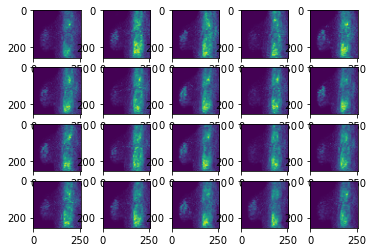

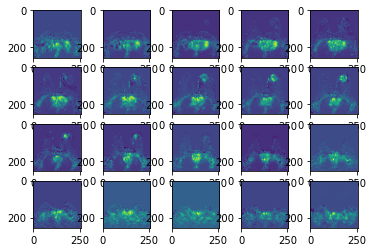

In [18]:
# visualize augmented images
IMG_PX_SIZE = 256
for scan in images[80:82]:
    #print len(slices), slices[0].pixel_array.shape, label
    fig = plt.figure()
    for num, each_slice in enumerate(scan[:20]):
        y = fig.add_subplot(4,5,num+1)
        new_image = cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_image)
    plt.show()

In [ ]:
for batch_idx in range(1000):
    # 'images' should be either a 4D numpy array of shape (N, height, width, channels)
    # or a list of 3D numpy arrays, each having shape (height, width, channels).
    # Grayscale images must have shape (height, width, 1) each.
    # All images must have numpy's dtype uint8. Values are expected to be in
    # range 0-255.
    images = load_batch(batch_idx)
    images_aug = seq.augment_images(images)
    train_on_images(images_aug)

In [307]:
#[scan.pixel_array.shape for scan in scans]
#print(scans)

In [19]:
# extracting paths to patient dcm using nested for loop
listp = []
for patient in patients[:1]:
    #label = labels_brca.get_value(patient,'class2')
    [listp.append(data_dir+'/'+patient+'/'+x+'/'+y+'/'+z) 
                  for x in os.listdir(data_dir+'/'+patient) 
     for y in os.listdir(data_dir+'/'+patient+'/'+x)[:1]
     for z in os.listdir(data_dir+'/'+patient+'/'+x+'/'+y) ]
    #slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
#print listp[0]

In [28]:
# get class value for each patient
#df.B.values[df.A.values == 23] # 60.3 µs per loop
#df['B'].loc[df.A.values == 23] #  197 µs
#print labels_brca['y'][labels_brca['patients']=='TCGA-AO-A03M']
#print labels_brca.loc[labels_brca['patients'] == 'TCGA-AO-A03M']

381    0
Name: y, dtype: int64


In [97]:
# read in dicom to array of lists with metadata
for patient in patients[:4]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1]
     for z in os.listdir(path+'/'+x+'/'+y)[:1] ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    print len(slices), slices[0].pixel_array.shape, slices[0].SliceThickness, label 
    #print slices[0].SeriesDescription, slices[0].PatientOrientation

1 (512L, 512L) 3 [0]
1 (256L, 256L) 3 [0]
1 (256L, 256L) 3 [0]
1 (256L, 256L) 3 [1]


In [8]:
# exclude non-MRI studies
for patient in patients[35:40]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             if len(os.listdir(path+'/'+x+'/'+y))>=12
             ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    #if len(slices) > 112 :
    print len(slices)#, slices[0].pixel_array.shape, slices[0].SliceThickness, label 
    #print slices[0].SeriesDescription, slices[0].PatientOrientation
    #mod = []
    #mod = [x if x.Modality == 'MR' for x in slices]
    #mod = [x.Modality for x in slices]
    #print mod
    # [a if C else b for i in items]
    # [x+1 if x >= 45 else x+5 for x in l]
    # [y for y in a if y not in b]
    # [ expression for item in list if conditional ]
    #print slices[0]
    #print slices[0].SOPClassUID
    #print slices[0].Modality
    #plt.imshow(slices[10].pixel_array)
    #plt.show()
#slices = [slice for slice in slices if len(slices) > 5 ]

SyntaxError: invalid syntax (<ipython-input-8-c594a8e9456e>, line 15)

In [200]:
# exclude scans less than 12 slices
for patient in patients[35:40]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices =[]
    for x in os.listdir(path):
        for y in os.listdir(path+'/'+x)[:1]:
            for z in os.listdir(path+'/'+x+'/'+y):
                if len(os.listdir(path+'/'+x+'/'+y))>=12:
                    #print len(os.listdir(path+'/'+x+'/'+y))
                    if ((dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
                        and len(os.listdir(path+'/'+x+'/'+y))>=12):
                        slices.append(dicom.read_file(path+'/'+x+'/'+y+'/'+z))
            
    #'{}{}{}'.format()
#    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
#                  for x in os.listdir(path) 
#     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
#     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
#              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
#             if len(os.listdir(path+'/'+x+'/'+y))>=12]
    
                        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices :
        print len(slices), slices[0].pixel_array.shape, slices[0].SliceThickness, label 
    

 70 (512L, 512L) 2.0 [0]
72 (512L, 512L) 2.0 [0]
480 (512L, 512L) 2 [0]
58 (256L, 256L) 7 [0]


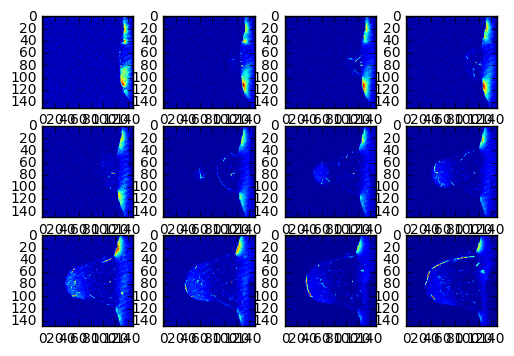

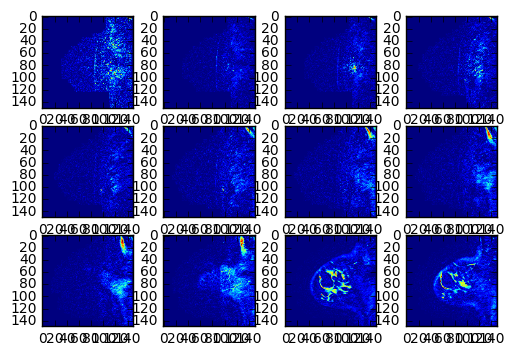

In [107]:
IMG_PX_SIZE = 150

for patient in patients[10:12]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             and len((dicom.read_file(path+'/'+x+'/'+y+'/'+z)) >=12)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    fig = plt.figure()
    for num, each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_image = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_image)
    plt.show()

In [11]:
IMG_PX_SIZE = 150
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
for patient in patients[5:10]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             if len(os.listdir(path+'/'+x+'/'+y))>=12
             ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices)/HM_SLICES))
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    print (len(slices), len(new_slices))
    '''
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()
    '''

430 20
46 16
45 15
36 18
53 18


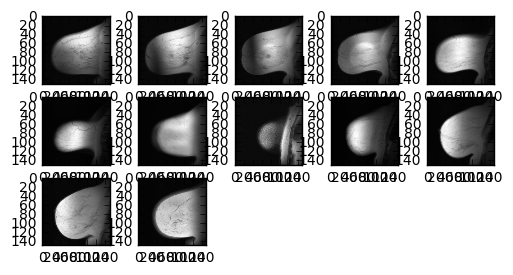

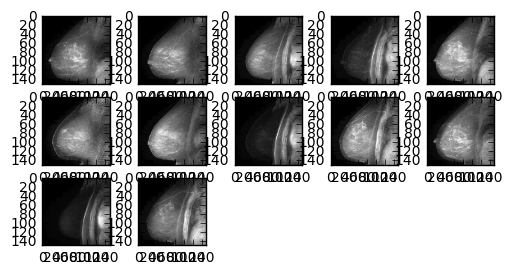

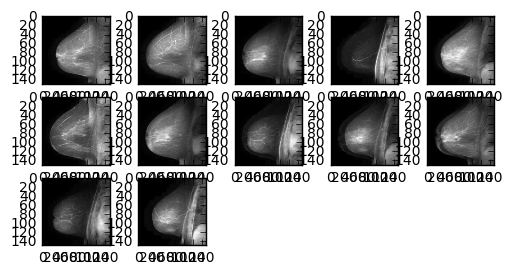

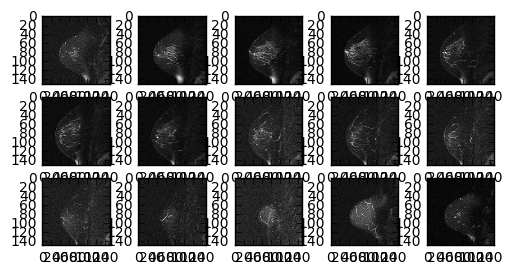

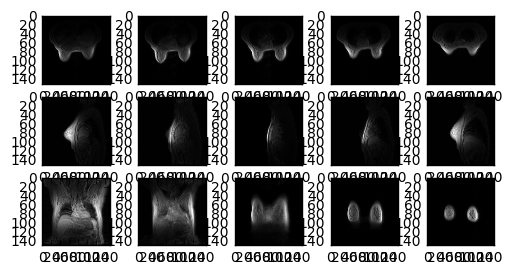

In [125]:
IMG_PX_SIZE = 150
HM_SLICES = 12

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
for patient in patients[100:105]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR']
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices)/HM_SLICES))
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    #print len(slices), len(new_slices)
    #'''
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()
    #'''

In [12]:
IMG_PX_SIZE = 50
HM_SLICES = 12

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
def process_data(patient, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:5] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
               if len(os.listdir(path+'/'+x+'/'+y))>=12
                 ]
    #slices = [x_slice for x_slice in slices if len(x_slice) > 20]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    if slices :
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = int(round(len(slices)/HM_SLICES))

        for slice_chunk in chunks(slices,chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        #print len(slices), len(new_slices)
        if visualize:
            fig = plt.figure()
            for num, each_slice in enumerate(new_slices):
                y = fig.add_subplot(4,5,num+1)
                y.imshow(each_slice, cmap='gray')
            plt.show()

        if label==1:
            label = np.array([0,1])
        elif label==0:
            label = np.array([1,0])

        return np.array(new_slices), label
    
    else :
        return [], label

much_data = []
for num, patient in enumerate(patients):
    if num%5==0:
        print (num)
        
    try:
        img_data, label = process_data(patient, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        
        if (img_data != [] and img_data.shape == (12, 50, 50)):
            print (img_data.shape, label)
            much_data.append([img_data, label])
    except KeyError as e:
        print ('unlabeled')
        
#np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

0


c:\users\toby\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


(12, 50, 50) [1 0]
(12, 50, 50) [1 0]
(12, 50, 50) [1 0]
(12, 50, 50) [0 1]
(12, 50, 50) [1 0]
5


KeyboardInterrupt: 

In [383]:
print(scan_paths[:3])
print('Hello')

['C:\\TCIA-BRCA\\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.105050108785380600324694049408', 'C:\\TCIA-BRCA\\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.106067388983457614790455949431', 'C:\\TCIA-BRCA\\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.112423030568957082578123456874']
Hello


In [414]:
# more images

data_dir = 'C:\TCIA-BRCA\DOI'

IMG_PX_SIZE = 50
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
def process_data(scan_path, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    #print(scan_path)
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if (slices[0].Modality=='MR' and len(slices)>=20) :
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        patient = slices[0].PatientID
        label = labels_brca['y'][labels_brca['patients']==patient].values
        #print (patient, len(slices), slices[0].pixel_array.shape, label,slices[0].Modality)
        
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        #img = cv.resize(img, (800, 800))
        #cv.normalize(img, img, 0, 255, cv.NORM_MINMAX)

        chunk_sizes = int(round(len(slices)/HM_SLICES))

        for slice_chunk in chunks(slices,chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)
        
        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            
        if len(new_slices) == HM_SLICES-3:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val
        
        if len(new_slices) == HM_SLICES+3:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-2] = new_val
        
        if len(new_slices) == HM_SLICES+4:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-3] = new_val
            
        if len(new_slices) == HM_SLICES+5:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-3] = new_val

        if visualize:
            fig = plt.figure()
            for num, each_slice in enumerate(new_slices):
                y = fig.add_subplot(4,5,num+1)
                y.imshow(each_slice, cmap='gray')
                plt.show()
        
        if label==1:
            label = np.array([0,1])
        elif label==0:
            label = np.array([1,0])

        return np.array(new_slices), label

    else :
        label = 0
        return np.empty([1,1]), label

much_data = []
for num, scan_path in enumerate(scan_paths):
    if num%25==0:
        print (num)
        
    try:
        img_data, label = process_data(scan_path, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        #print (img_data.shape, label)
        if img_data.shape == (20, 50, 50):
            #print (img_data.shape, label)
            much_data.append([img_data, label])
    except KeyError as e:
        print ('unlabeled')

len(much_data)
#np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875


1554

In [415]:
np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

In [32]:
much_data = np.load('muchdata-50-50-20.npy')

In [536]:
print(much_data[:,1])

[array([1, 0]) array([1, 0]) array([1, 0]) array([1, 0]) array([1, 0])
 array([1, 0]) array([1, 0]) array([1, 0]) array([1, 0]) array([1, 0])]


In [498]:
from sklearn.preprocessing import StandardScaler
#print (much_data[:2])
much_data_array = np.asarray(much_data)
#print (much_data_array[:2,1])

much_data_img = much_data_array[:,0]
much_data_label = much_data_array[:,1]
much_data_label = much_data_label.reshape(much_data_label.shape[0],1)

print(much_data_label.shape)
print(len(much_data_label))
print(much_data_label[:4])
#print (much_data_array[:2,0])
#print (much_data_norm[:1])
#np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_norm)
#print (much_data[:1])

(1554, 1)
1554
[[array([1, 0])]
 [array([1, 0])]
 [array([1, 0])]
 [array([1, 0])]]


In [538]:
sum(x == ([0,1]) for x in much_data[:,1])

array([89, 89])

In [499]:
#much_data_img[1550].shape
much_data_img = np.asarray(much_data_img)
print (much_data_img[1200].dtype)

float64


In [500]:
from sklearn.preprocessing import normalize
#print(much_data_array.shape)
#data_flat = much_data_img.reshape(50*50*20,much_data_img.shape[0])
#print(data_flat.shape)

#scaler = StandardScaler()
#scaler = scaler.fit(much_data_img)
#print (much_data[:1])
#much_data_norm = normalize(much_data_img, axis=0, norm='l1')
#much_data_norm = scaler.transform(much_data_img)

data_mean = np.mean(much_data_img)
data_sd = np.std(much_data_img)
much_data_norm = [(x-data_mean)/data_sd for x in much_data_img]
much_data_norm = np.asarray(much_data_norm)
print(much_data_norm.shape)

(1554, 20, 50, 50)


In [510]:
#print(much_data_norm[:1])
#much_data_array = np.insert(much_data_norm, np.arange(len(much_data_label)), much_data_label, axis=0)
#much_data_array = [y for x in zip(much_data_norm, much_data_label) for y in x]
much_data_array = [x for x in zip(much_data_norm, much_data_label)]
#print(much_data_array[0])
#print(much_data[0])
print(len(much_data_array))
print(len(much_data))

1554
1554


In [501]:
for data in (much_data_norm[:2],much_data_label[:2]):
    #print(data)
    x = data[0]
    y = data[1]
    print(x.shape)
    print(y.shape)

(20, 50, 50)
(20, 50, 50)
(1,)
(1,)


In [511]:
np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_array)

In [33]:
print(much_data[0])

[ array([[[   0. ,    0. ,    0. , ...,   70.5,   53. ,   29. ],
        [   0. ,    0. ,    0. , ...,   76. ,   58. ,   32. ],
        [   0. ,    0. ,    0. , ...,   35.5,   42. ,   38.5],
        ..., 
        [   0. ,    0. ,    0. , ...,   38. ,   38. ,    8. ],
        [   0. ,    0. ,    0. , ...,   26.5,   27. ,   23.5],
        [   0. ,    0. ,    0. , ...,   60.5,   26.5,   31.5]],

       [[   0. ,    0. ,    0. , ...,   98. ,   75. ,   41.5],
        [   0. ,    0. ,    0. , ...,   72.5,   19.5,   45. ],
        [   0. ,    0. ,    0. , ...,   24. ,   57.5,   93.5],
        ..., 
        [   0. ,    0. ,    0. , ...,   31. ,   34.5,   36. ],
        [   0. ,    0. ,    0. , ...,   42. ,   53.5,   34.5],
        [   0. ,    0. ,    0. , ...,   33.5,   42.5,   38. ]],

       [[   0. ,    0. ,    0. , ...,   53. ,   27.5,   10.5],
        [   0. ,    0. ,    0. , ...,   21. ,   43.5,   34.5],
        [   0. ,    0. ,    0. , ...,   89. ,   80. ,   57. ],
        ..., 
       

In [ ]:
# image augmentation

In [379]:
import tensorflow as tf
import numpy as np
print('Hello')

Hello


In [380]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [381]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [382]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [514]:
# split into train and test
from sklearn.model_selection import train_test_split

much_data_model = np.load('muchdata-norm-50-50-20.npy')
X_train, X_test, y_train, y_true = train_test_split(much_data_model[:,0], much_data_model[:,1], test_size=0.30, random_state=62)


# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
#train_data = much_data[:-300]
#validation_data = much_data[-300:]
#validation_data = [x for x in validation_data if x[0].shape == (20, 50, 50)]

train_data = [x for x in zip(X_train, y_train)]
validation_data = [x for x in zip(X_test, y_true)]
train_data = np.asarray(train_data)
validation_data = np.asarray(validation_data)

#print(much_data[0][0].shape)
print(len(train_data))
print(len(validation_data))

1087
467


In [522]:
print(validation_data[:,1][0])

[array([1, 0])]


In [526]:
# count class

#labels_brca.y.value_counts()
#labels_brca.ix[-35:].y.value_counts()
#validation_data[label.value_counts()

#train_data[:,1]
#validation_data[:,1]

sum(x == ([0,1]) for x in train_data[:,1])

#np.where(validation_data[:,1]==[1,0]).shape
#np.unique(train_data[:,1])
#unique_elements, counts_elements = np.unique(train_data[:,1].any(), return_counts=True)
#print("Frequency of unique values of the said array:")
#print(np.asarray((unique_elements, counts_elements)))

c:\users\toby\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


0

In [374]:
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    saver = tf.train.Saver()
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        # save model
        
        saver.save(sess, 'brca-tf-cnn-model')
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

Epoch 1 completed out of 10 loss: 7830709112.0
Accuracy: 0.86
Epoch 2 completed out of 10 loss: 284674178.875
Accuracy: 0.853333
Epoch 3 completed out of 10 loss: 119598938.813
Accuracy: 0.86
Epoch 4 completed out of 10 loss: 83184220.25
Accuracy: 0.843333
Epoch 5 completed out of 10 loss: 22427807.0938
Accuracy: 0.86
Epoch 6 completed out of 10 loss: 11707436.0938
Accuracy: 0.86
Epoch 7 completed out of 10 loss: 46858782.5781
Accuracy: 0.86
Epoch 8 completed out of 10 loss: 59444183.0938
Accuracy: 0.86
Epoch 9 completed out of 10 loss: 10231331.0625
Accuracy: 0.86
Epoch 10 completed out of 10 loss: 42926038.8125
Accuracy: 0.86
Done. Finishing accuracy:
Accuracy: 0.86
fitment percent: 1.0


In [ ]:
# rna & clinical

In [544]:
rna = pd.read_table('D:\Insight\RNASeq2.txt',
                  sep='\t', na_values='NA',low_memory=False )
#rna = pd.read_csv('D:\Insight\gdac.broadinstitute.org_BRCA.Merge_rnaseq__illuminahiseq_rnaseq__unc_edu__Level_3__gene_expression__data.Level_3.2016012800.0.0 (1).tar\BRCA.rnaseq__illuminahiseq_rnaseq__unc_edu__Level_3__gene_expression__data.data.txt',
#                  sep='\t', na_values='NA',low_memory=False )
rna = rna.drop(['pat.bcr','stage', 'class.y', 'patient.stage_event.pathologic_stage'],axis=1)
#class.x  class.y  patient.stage_event.pathologic_stage
print(rna.head())

   ?|100130426  ?|100133144  ?|100134869    ?|10357     ?|10431  ?|136542  \
0          0.0     4.740894     1.850690  21.147799   85.855098       0.0   
1          0.0     5.538907     2.289837  13.757862  164.300537       0.0   
2          0.0     4.852649     2.258469  30.817610  260.711091       0.0   
3          0.0     2.738411     1.568381  17.688679  138.959750       0.0   
4          0.0     2.839404     1.474279  14.306604  142.381038       0.0   

    ?|155060   ?|26823  ?|280660  ?|317712   ...     ZXDB|158586  ZXDC|79364  \
0  17.243280  0.827206       0.0       0.0   ...       14.145284   64.301618   
1   7.731220  1.643382       0.0       0.0   ...       21.564148   79.748326   
2  11.166437  1.183824       0.0       0.0   ...       37.068483   94.620257   
3  17.741902  0.091912       0.0       0.0   ...       14.219784   48.010603   
4  16.554101  0.693015       0.0       0.0   ...       13.020350   55.540458   

   ZYG11A|440590  ZYG11B|79699    ZYX|7791  ZZEF1|23140 

In [545]:
print(rna.shape)

(878, 20533)


In [546]:
# Label Encoder
encoder = LabelEncoder()
encoder.fit(rna["class.x"])
rna['class'] = encoder.transform(rna["class.x"])
rna = rna.drop(['class.x'],axis=1)

In [551]:
#print (rna['class'][10:30])
print(sum([x == 1 for x in rna['class']]))
print(sum([x != 1 for x in rna['class']]))

95
783


In [552]:
rna_class = rna['class']
print (rna_class.head())
rna = rna.drop('class', axis=1)
print(rna.head())

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64
   ?|100130426  ?|100133144  ?|100134869    ?|10357     ?|10431  ?|136542  \
0          0.0     4.740894     1.850690  21.147799   85.855098       0.0   
1          0.0     5.538907     2.289837  13.757862  164.300537       0.0   
2          0.0     4.852649     2.258469  30.817610  260.711091       0.0   
3          0.0     2.738411     1.568381  17.688679  138.959750       0.0   
4          0.0     2.839404     1.474279  14.306604  142.381038       0.0   

    ?|155060   ?|26823  ?|280660  ?|317712     ...       ZXDA|7789  \
0  17.243280  0.827206       0.0       0.0     ...        7.451490   
1   7.731220  1.643382       0.0       0.0     ...       11.567914   
2  11.166437  1.183824       0.0       0.0     ...       18.173250   
3  17.741902  0.091912       0.0       0.0     ...        5.844075   
4  16.554101  0.693015       0.0       0.0     ...        5.302148   

   ZXDB|158586  ZXDC|79364  ZYG11A|440590  ZYG11B|79699

In [553]:
# Normalize
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(rna)
rna_scaled = scaler.transform(rna)
rna_norm = pd.DataFrame(rna_scaled, columns = rna.columns)
#rna = pd.DataFrame(rna)
rna_norm.head()

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
0,-0.394018,0.004135,-0.083980,-0.259281,-1.122976,-0.140814,0.044922,-0.410354,-0.086475,-0.050736,...,-0.376954,-0.670711,-0.473050,-0.906080,-0.222213,0.234640,-0.076043,-0.104028,0.396917,-0.140999
1,-0.394018,0.335760,0.254234,-0.609912,-0.307966,-0.140814,-0.729964,0.670680,-0.086475,-0.050736,...,0.459657,-0.226771,0.043002,-0.723470,-0.354528,-0.225956,-0.245852,0.130250,-0.368559,-0.749939
2,-0.394018,0.050576,0.230075,0.199523,0.693693,-0.140814,-0.450119,0.061989,-0.086475,-0.050736,...,1.802107,0.700997,0.539851,-0.271005,0.478702,0.494169,-0.031611,0.581650,2.183050,0.011236
3,-0.394018,-0.828023,-0.301403,-0.423406,-0.571244,-0.140814,0.085542,-1.384259,-0.086475,-0.050736,...,-0.703641,-0.666252,-1.017308,-0.471351,-0.950302,-0.076471,-1.071846,-1.188969,-0.510984,-0.902174
4,-0.394018,-0.786054,-0.373877,-0.583875,-0.535699,-0.140814,-0.011221,-0.588092,-0.086475,-0.050736,...,-0.813781,-0.738026,-0.765747,-1.040926,-0.999555,-0.832589,-0.126685,-1.008379,-0.547915,-0.826056


In [556]:
# split into train and test
from sklearn.model_selection import train_test_split

X, y = rna_norm, rna_class
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=62)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_true.shape)
print (y_true.value_counts())

#return X_train, X_test, y_train, y_true

(658, 20532)
(220, 20532)
(658,)
(220,)
0    186
1     34
Name: class, dtype: int64


In [573]:
print(y_train.value_counts())
print(y_true.value_counts())

0    597
1     61
Name: class, dtype: int64
0    186
1     34
Name: class, dtype: int64


In [136]:
# zero and near zero variance
from sklearn.feature_selection import VarianceThreshold
#selector = VarianceThreshold()
#rna_var = selector.fit_transform(rna_norm)
#rna_var.shape[1]
#rna_norm = pd.DataFrame(rna_var, columns = rna.columns)
#rna_norm = pd.DataFrame(rna_var)
#rna_norm.head()

In [559]:
# univariate feature selection
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=10)
rna_uni = selector.fit_transform(rna_norm, rna_class)
rna_uni = pd.DataFrame(rna_uni)
print(rna_uni.head())
#print(selector.scores_)

       0         1         2         3         4         5         6     \
0 -0.876945 -0.658073  0.005208 -0.459216 -0.757156 -0.555145 -1.240482   
1 -0.471990 -0.741155 -0.068459 -0.604126  0.561029 -0.186127 -0.098282   
2  0.206399  1.268370 -0.071689  0.131122  0.132834  0.511981  1.042713   
3 -0.514735  0.105529 -0.072398 -0.919402 -0.796327 -0.827636  0.028308   
4 -0.269094 -0.754165  0.019941 -0.831437 -0.655735 -0.692319  0.043350   

       7         8         9       ...         2044      2045      2046  \
0 -0.579285 -0.120885 -0.584470    ...    -0.609626 -0.272817 -0.412677   
1 -0.000274  0.075101  0.798404    ...    -0.257874 -0.598042 -0.540950   
2 -0.395315 -0.129456 -0.718309    ...    -0.104042  2.229529  1.330332   
3 -0.810617 -0.110298 -0.618771    ...    -0.403371  0.272828  0.250210   
4 -0.274831 -0.132884 -0.839024    ...     0.336588 -0.342687 -0.316105   

       2047      2048      2049      2050      2051      2052      2053  
0 -0.589305 -0.829414 -1

c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7662  7665 15140 15141 16743 16749 16762 16764] are constant.
  UserWarning)
c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
# split into train and test
X, y = rna_uni, rna_class
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=62)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_true.shape)
print (y_true.value_counts())

#return X_train, X_test, y_train, y_true

In [ ]:
# Random Forest for feature selection
from sklearn.ensemble import RandomForestClassifier

paramsrf = {'n_estimators': 1500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
           'n_jobs': -1}

def RFmodel(train_data, train_class, test_data):
    """
    RF model
    """
    clf = RandomForestClassifier(**paramsrf).fit(train_data, train_class)
    y_pred = clf.predict(test_data)
    probs = clf.predict_proba(test_data)[:, 1]
    return y_pred, probs


In [ ]:
y_pred, probs = RFmodel(rna_pca_train, y_train, rna_pca_test)
print (modelEval(y_true, y_pred, probs))

In [557]:
# remove highly correlated variables
def correlation(dataset, threshold=0.7):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

#rna_corr = correlation(rna_norm, threshold=0.7)
#print(rna_corr.head())

In [264]:
print('Hello')

Hello


In [ ]:
# Recursive Feature Elimination

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X, y = rna_norm, rna_class

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [566]:
# pca
from sklearn.decomposition import PCA

#def pca(data, n_components=None):
pca = PCA(n_components=400, random_state=0)
pca.fit(X_train)
rna_pca_train = pca.transform(X_train)
rna_pca_test = pca.transform(X_test)
#print(pca.explained_variance_ratio_)

#rna_vars = pca(data, n_components=None)
#rna_vars.head()

In [564]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#print(var1)

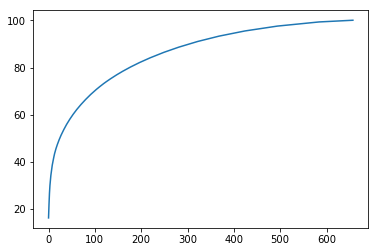

In [565]:
plt.plot(var1)

In [567]:
# Random Forest for feature selection
from sklearn.ensemble import RandomForestClassifier

paramsrf = {'n_estimators': 1500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
           'n_jobs': -1}

def RFmodel(train_data, train_class, test_data):
    """
    RF model
    """
    clf = RandomForestClassifier(**paramsrf).fit(train_data, train_class)
    y_pred = clf.predict(test_data)
    probs = clf.predict_proba(test_data)[:, 1]
    return y_pred, probs


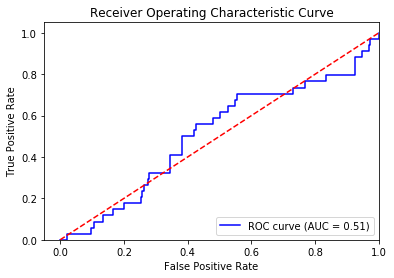

Sensitivity:  0.0
Specificity:  1.0
Accuracy:  0.845454545455
F1 score:  0.0
AUC:  0.509487666034
AUC2:  0.509487666034
Precision:  0.71479338843




c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [568]:
y_pred, probs = RFmodel(rna_pca_train, y_train, rna_pca_test)
print (modelEval(y_true, y_pred, probs))

In [255]:
def GBMmodel(train_data, train_class, test_data):
    """
    Takes arrays of training data (predictors and class) and test data 
    Uses the Gradient Boosting classifier to classify 
    the diabetic and non-diabetic patients
    Fits the model and predicts on the test data
    Returns predicted class values "y_pred" and predicted probabilities "probs"
    """
    clf = ensemble.GradientBoostingClassifier(**params).fit(train_data, train_class)
    y_pred = clf.predict(test_data)
    probs = clf.predict_proba(test_data)[:, 1]
    return y_pred, probs

In [24]:
# evaluate
import sklearn.metrics as metrics

def modelEval(test_class, pred, probabs):
    """
    Takes the arrays of actual class values, the predicted class values and 
    their probabilites, computes the confusion matrix, tpr and fpr and auc.
    Plots the ROC curve, and returns model evaluation metrics- sensitivity,
    specificity, accuracy, F1 score and AUC
    """
    cm = metrics.confusion_matrix(test_class, pred)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    fpr, tpr, threshold = metrics.roc_curve(test_class, probabs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05,1)
    plt.ylim(0,1.05)
    plt.show()
    sens = tp / float(tp + fn)
    print ('Sensitivity: ', sens)
    specf = tn / float(fp + tn)
    print ('Specificity: ', specf)
    accu = metrics.accuracy_score(test_class, pred)
    print ('Accuracy: ', accu) 
    f1s = metrics.fbeta_score(test_class, pred, beta=1)
    print ('F1 score: ', f1s)
    auc1 = metrics.auc(fpr, tpr)
    print ('AUC: ', auc1)
    auc2 = metrics.roc_auc_score(y_true, probabs)
    print ('AUC2: ', auc2)
    precision = metrics.precision_score(test_class, pred, average='weighted')
    print ('Precision: ', precision) 
    return "\n"


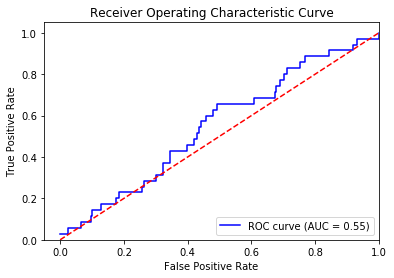

Sensitivity:  0.0
Specificity:  1.0
Accuracy:  0.867424242424
F1 score:  0.0
AUC:  0.54984404242
AUC2:  0.54984404242
Precision:  0.752424816345




c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [257]:
y_pred, probs = GBMmodel(rna_pca_train, y_train, rna_pca_test)
print (modelEval(y_true, y_pred, probs))

In [246]:
# gbm, xgboost, ann
from sklearn import ensemble
from sklearn.model_selection import KFold
#rna_pca_train
#rna_pca_test

params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(rna_pca_train, y_train)
acc = clf.score(rna_pca_test, y_true)
print("Accuracy: {:.4f}".format(acc))

Accuracy: 0.8674


In [581]:
# Pipeline -- logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

logistic = linear_model.LogisticRegression()
GNB = GaussianNB()
RF =  RandomForestClassifier()
GBM = ensemble.GradientBoostingClassifier()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

pca.fit(X_train)

# Prediction
n_components = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000]
Cs = np.logspace(-4, 4, 3)
GBMparams = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
RFparams= {'n_estimators': 1500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
           'n_jobs': -1}
gbmparam_dist = {"max_depth": [3, 5],
              "n_estimators": [500, 1000,1500],
              "learning_rate": [0.1, 0.01, 0.001],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "subsample": [0.5,1.0],
              #"bootstrap": [True, False],
              "criterion": ["friedman_mse", "mae"]
             }


# Randomized Search
# n_iter_search = 20
#random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                   n_iter=n_iter_search)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs), cv=4, scoring='roc_auc')
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
probs = estimator.decision_function(X_test)
#probs = estimator.predict_proba(X_test)[:, 1]
print(estimator.best_params_)

{'logistic__C': 10000.0, 'pca__n_components': 600}


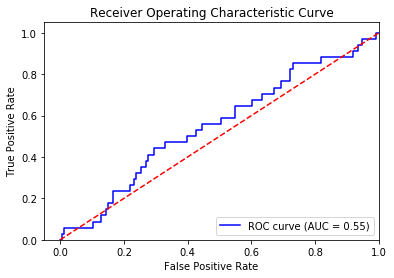

Sensitivity:  0.147058823529
Specificity:  0.849462365591
Accuracy:  0.740909090909
F1 score:  0.149253731343
AUC:  0.551865907653
AUC2:  0.551865907653
Precision:  0.737757251661




In [580]:
print (modelEval(y_true, y_pred, probs))

In [ ]:
# SVM model

def buildSVMModel(X_train, y_train, X_test):
    """
    Takes training and testing data and extracts selected features.
    Uses a grid search to select which parameters to use with the
    SVM model and returns the model and the test data features
    """                      
    # GridSearchCV                     
    #parameters = {'kernel':('linear', 'rbf','poly'), 
    #              'C':[0.01, 0.1, 1, 10, 100, 1000], 
    #              'gamma':[0.0001,0.001,0.01, 0.1, 1,10],
    #              'degree':[2,3]}
    #svr = svm.SVC()
    #clf = GridSearchCV(svr, parameters)
    #clf.fit(X_train, y_train)
    #print clf.best_params_
    # build model with selected features and parameters
    X_train2 = X_train[:,(2,0)]
    X_test2 = X_test[:,(2,0)]
    svr = svm.SVC(kernel='rbf',C=1,gamma=10)
    svr.fit(X_train2, y_train)
    return svr, X_test2

In [ ]:
y_pred, probs = GBMmodel(rna_pca_train, y_train, rna_pca_test)
print (modelEval(y_true, y_pred, probs))

In [ ]:
# Clinical

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
clin = pd.read_csv('D:\Insight\clin_low.txt', sep='\t', na_values='NA')
#clin = pd.read_csv('D:\Insight\gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0\gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0\BRCA.clin.merged.txt',
#                  sep='\t', na_values='NA')
print(clin.head())

   patient.age       patient.ethnicity patient.gender  \
0         42.0      hispanic or latino         female   
1         63.0      hispanic or latino         female   
2         40.0  not hispanic or latino         female   
3         38.0  not hispanic or latino         female   
4         53.0                     NaN         female   

                            patient.menopause_status  \
0  post (prior bilateral ovariectomy or >12 mo si...   
1  post (prior bilateral ovariectomy or >12 mo si...   
2                                                NaN   
3  pre (<6 months since lmp and no prior bilatera...   
4  post (prior bilateral ovariectomy or >12 mo si...   

  patient.anatomic_neoplasm_subdivisions.anatomic_neoplasm_subdivision  \
0                                              right                     
1                                               left                     
2                                              right                     
3                       

In [42]:
clin.shape

(1097, 13)

In [43]:
clin.describe()

,patient.age
count,1082.000000
mean,58.563771
std,13.175121
min,26.000000
25%,49.000000
50%,59.000000
75%,68.000000
max,89.000000


In [44]:
clin.dtypes

patient.age                                                             float64
patient.ethnicity                                                        object
patient.gender                                                           object
patient.menopause_status                                                 object
patient.anatomic_neoplasm_subdivisions.anatomic_neoplasm_subdivision     object
patient.breast_carcinoma_estrogen_receptor_status                        object
patient.breast_carcinoma_progesterone_receptor_status                    object
patient.lab_proc_her2_neu_immunohistochemistry_receptor_status           object
patient.other_dx                                                         object
patient.race_list.race                                                   object
patient.omfs.omf.malignancy_type                                         object
class                                                                    object
stage                                   

In [45]:
# missing values
clin.isnull().any()

patient.age                                                              True
patient.ethnicity                                                        True
patient.gender                                                          False
patient.menopause_status                                                 True
patient.anatomic_neoplasm_subdivisions.anatomic_neoplasm_subdivision    False
patient.breast_carcinoma_estrogen_receptor_status                        True
patient.breast_carcinoma_progesterone_receptor_status                    True
patient.lab_proc_her2_neu_immunohistochemistry_receptor_status           True
patient.other_dx                                                         True
patient.race_list.race                                                   True
patient.omfs.omf.malignancy_type                                         True
class                                                                   False
stage                                                           

In [46]:
clin['patient.age'] = clin['patient.age'].fillna(clin['patient.age'].mean())

In [47]:
clin = clin.fillna('None')
# df = df.fillna(df['Label'].value_counts().index[0])
# to fill categorical missing values with mode

In [48]:
# LabelEncoder
le = LabelEncoder()

# apply "le.fit_transform"
clin_encoded = clin.apply(le.fit_transform)
print(clin_encoded.head())

   patient.age  patient.ethnicity  patient.gender  patient.menopause_status  \
0           16                  1               0                         3   
1           38                  1               0                         3   
2           14                  2               0                         0   
3           12                  2               0                         4   
4           27                  0               0                         3   

   patient.anatomic_neoplasm_subdivisions.anatomic_neoplasm_subdivision  \
0                                                  5                      
1                                                  0                      
2                                                  5                      
3                                                  7                      
4                                                  9                      

   patient.breast_carcinoma_estrogen_receptor_status  \
0                 

In [49]:
clin_class = clin_encoded['class']
print (clin_class.head())
#clin = clin.drop('y', axis=1)
#print(clin.head())

0    0
1    1
2    0
3    0
4    0
Name: class, dtype: int64


In [50]:
clin_encoded = clin_encoded.drop(['stage', 'class'],axis=1)
#class.x  class.y  patient.stage_event.pathologic_stage
#print(clin.head())

In [160]:
# one-hot encoding
clin_enc = pd.get_dummies(clin)
#print(clin_enc.head())

In [161]:
#clin_enc = clin_enc.fillna(0)

## Modeling

In [105]:
# split into train and test
from sklearn.model_selection import train_test_split

X, y = clin_encoded, clin_class
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=62)
print(X_train.shape)
print(X_test.shape)
print (y_true.value_counts())

(822, 11)
(275, 11)
0    237
1     38
Name: class, dtype: int64


In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train 
                         #,columns = clin_encoded.columns
                        )
X_test = pd.DataFrame(X_test)
#rna = pd.DataFrame(rna)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.516508,0.484853,-0.085749,-2.860881,-1.505749,0.507067,-0.798357,-1.021462,-0.24648,-0.326084,-0.264097
1,-0.964525,0.484853,-0.085749,-2.860881,-0.169473,0.507067,0.643950,0.472562,-0.24648,0.527549,-0.264097
2,-1.188533,0.484853,-0.085749,1.101451,-0.503542,0.507067,-0.798357,0.472562,-0.24648,0.527549,-0.264097
3,1.872911,-2.208045,-0.085749,0.110868,-1.171680,0.507067,0.643950,0.472562,-0.24648,-2.886982,-0.264097
4,0.379524,0.484853,-0.085749,0.110868,0.832734,0.507067,0.643950,1.219575,-0.24648,0.527549,-0.264097


In [107]:
# univariate feature selection
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print(X_train.head())
print(selector.scores_)
print(selector.pvalues_)

          0         1         2         3         4
0 -0.516508  0.484853 -2.860881 -1.021462 -0.326084
1 -0.964525  0.484853 -2.860881  0.472562  0.527549
2 -1.188533  0.484853  1.101451  0.472562  0.527549
3  1.872911 -2.208045  0.110868  0.472562 -2.886982
4  0.379524  0.484853  0.110868  1.219575  0.527549
[ 5.55191056  1.17940835  0.79805353  5.75838256  0.0290151   0.30653887
  0.2411821   2.70646942  0.0154759   6.61767412  0.31327139]
[ 0.01869493  0.27779562  0.37193807  0.01663232  0.86478618  0.57996281
  0.62348505  0.1003252   0.90102734  0.01027205  0.57583249]


In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

In [49]:
# Plain SMOTE

# oversampling minority class using SMOTE (Synthetic Minority Oversampling Technique).
# https://beckernick.github.io/oversampling-modeling/
from imblearn.over_sampling import SMOTE
# after train_test_split
sm = SMOTE(random_state=12, ratio = 0.5)
X_train, y_train = sm.fit_sample(X_train, y_train)

c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [108]:
# Tomek SMOTE

# http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_smote_tomek.html
from imblearn.combine import SMOTETomek

# Apply SMOTE + Tomek links
sm = SMOTETomek()
X_train, y_train = sm.fit_sample(X_train, y_train)

In [81]:
# ENN SMOTE

# http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_smote_enn.html
from imblearn.combine import SMOTEENN

# Apply SMOTE + ENN
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_sample(X, y)

In [28]:
# select from RF model
from sklearn.feature_selection import SelectFromModel
clf= RandomForestClassifier()
sfm= SelectFromModel(clf,threshold=0.01)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_train).shape[1]
print(n_features)
X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)
X_train.shape

10


### Models

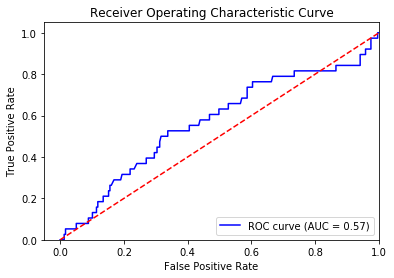

Sensitivity:  0.0
Specificity:  1.0
Accuracy:  0.861818181818
F1 score:  0.0
AUC:  0.570564068399
AUC2:  0.570564068399
Precision:  0.742730578512




c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
svr = SVC(kernel='rbf', C=10, gamma=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
probs = svr.decision_function(X_test)
print (modelEval(y_true, y_pred, probs))
#{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

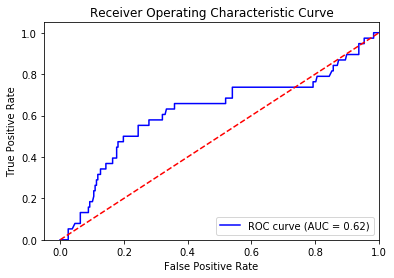

Sensitivity:  0.552631578947
Specificity:  0.755274261603
Accuracy:  0.727272727273
F1 score:  0.358974358974
AUC:  0.621641128137
AUC2:  0.621641128137
Precision:  0.823800521359




In [109]:
# Naive Bayes
NBmodel = GaussianNB().fit(X_train, y_train)
y_pred = NBmodel.predict(X_test)
probs = NBmodel.predict_proba(X_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

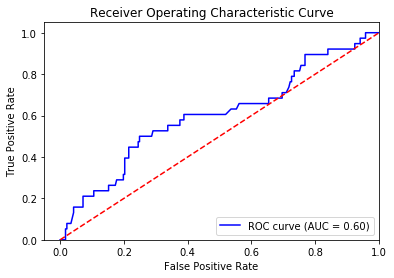

Sensitivity:  0.447368421053
Specificity:  0.759493670886
Accuracy:  0.716363636364
F1 score:  0.303571428571
AUC:  0.601376859871
AUC2:  0.601376859871
Precision:  0.803521948




In [115]:
# Random Forest for feature selection
from sklearn.ensemble import RandomForestClassifier

paramsrf = {'n_estimators': 500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
           'n_jobs': -1}

def RFmodel(train_data, train_class, test_data):
    """
    RF model
    """
    rf = RandomForestClassifier(**paramsrf).fit(train_data, train_class)
    y_pred = rf.predict(test_data)
    probs = rf.predict_proba(test_data)[:, 1]
    return rf, y_pred, probs

rf, y_pred, probs = RFmodel(X_train, y_train, X_test)
print (modelEval(y_true, y_pred, probs))

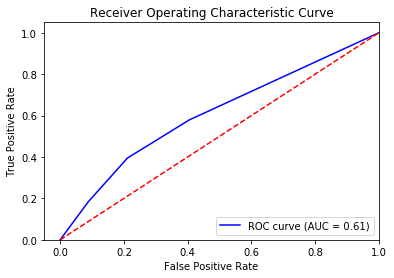

Sensitivity:  0.394736842105
Specificity:  0.789029535865
Accuracy:  0.734545454545
F1 score:  0.291262135922
AUC:  0.607761492338
AUC2:  0.607761492338
Precision:  0.799316683317




In [117]:
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(X_train, y_train) 
y_pred = estimator.predict(X_test)
probs = estimator.predict_proba(X_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

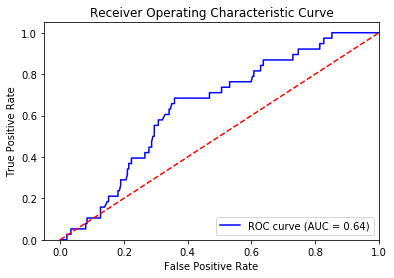

Sensitivity:  0.289473684211
Specificity:  0.805907172996
Accuracy:  0.734545454545
F1 score:  0.231578947368
AUC:  0.643959582501
AUC2:  0.643959582501
Precision:  0.781745899361




In [127]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': 800, 'max_depth': 4, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}

def GBMmodel(train_data, train_class, test_data):
    """
    Takes arrays of training data (predictors and class) and test data 
    Uses the Gradient Boosting classifier to classify 
    the diabetic and non-diabetic patients
    Fits the model and predicts on the test data
    Returns predicted class values "y_pred" and predicted probabilities "probs"
    """
    clf = GradientBoostingClassifier(**params).fit(train_data, train_class)
    y_pred = clf.predict(test_data)
    probs = clf.predict_proba(test_data)[:, 1]
    return y_pred, probs
y_pred, probs = GBMmodel(X_train, y_train, X_test)
print (modelEval(y_true, y_pred, probs))

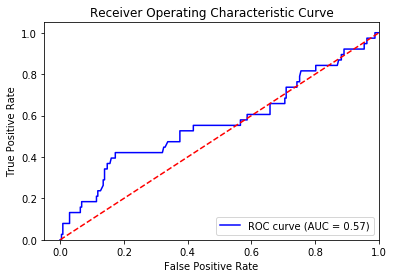

Sensitivity:  0.394736842105
Specificity:  0.827004219409
Accuracy:  0.767272727273
F1 score:  0.31914893617
AUC:  0.566400177659
AUC2:  0.566400177659
Precision:  0.808320583526




In [129]:
# MLP
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100, 100,50), 
                    random_state=1,verbose=10,early_stopping=True,validation_fraction=0.2,
                   learning_rate_init=0.001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

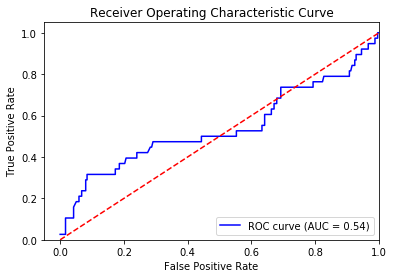

Sensitivity:  0.394736842105
Specificity:  0.784810126582
Accuracy:  0.730909090909
F1 score:  0.288461538462
AUC:  0.541638907395
AUC2:  0.541638907395
Precision:  0.798381905176




In [65]:
# MLP
from sklearn.neural_network import MLPClassifier
estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 100, 50), 
                    random_state=1,verbose=10,early_stopping=True,validation_fraction=0.2,
                   learning_rate_init=0.01)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
probs = estimator.predict_proba(X_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.3s
[Paralle

{'kernel': 'linear', 'gamma': 1, 'C': 0.1}
0.0


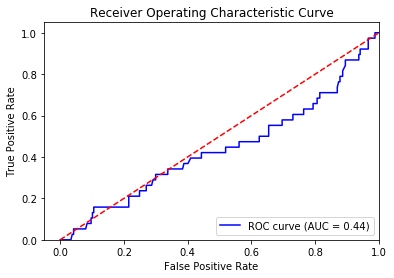

Sensitivity:  0.0
Specificity:  1.0
Accuracy:  0.861818181818
F1 score:  0.0
AUC:  0.440095491894
AUC2:  0.440095491894
Precision:  0.742730578512




c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
# Pipeline -- logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model, decomposition
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Logistic Regression
#logistic = linear_model.LogisticRegression()
#LRparameters = {'C':[0.000000001, 0.000001, 0.001, 0.01, 0.1, 1, 10,100, 1000]}
#clf = GridSearchCV(logistic, LRparameters, cv=4, scoring='recall')
#clf.fit(X_train, y_train)

# SVC
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.0000001, 0.001, 0.01, 0.1, 1, 10,100, 1000],
             'gamma':[0.0001,0.001,0.01, 0.1, 1,10]}
svc = svm.SVC()
#clf = GridSearchCV(svc, parameters, cv=3, scoring='recall')
#clf.fit(X_train, y_train)

# Naive Bayes
#NBmodel = GaussianNB().fit(X_train, y_train)
#y_pred = NBmodel.predict(X_test)
#probs = NBmodel.predict_proba(X_test)[:, 1]

# MLP
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100, 200, 100, 50, 20), 
#                    random_state=1,verbose=10,early_stopping=True,validation_fraction=0.2,
#                   learning_rate_init=0.001)
#clf.fit(X_train, y_train)

# Randomized Search
clf = RandomizedSearchCV(svc, parameters,n_iter=20,n_jobs=-1, verbose=20,cv=5,scoring='recall')
clf.fit(X_train, y_train)
#random_search.cv_results_

y_pred = clf.predict(X_test)
probs = clf.decision_function(X_test)
#probs = clf.predict_proba(X_test)[:, 1]
print(clf.best_params_)
print (clf.best_score_)
print (modelEval(y_true, y_pred, probs))

In [131]:
# Stacked Classifier (Ensemble Stacking, Super Learner, Metalearner)
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#example-1-simple-stacked-classification
# https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

def StackClassif(X, y, test):
    from sklearn import model_selection
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB 
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    from mlxtend.classifier import StackingClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    import numpy as np

    clf1 = KNeighborsClassifier(n_neighbors=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    lr = LogisticRegression()
    gbm = GradientBoostingClassifier()
    
    # stacking classifier
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                              meta_classifier=lr, use_probas = True)
    
    
    print('10-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3, sclf], 
                          ['KNN', 
                           'Random Forest', 
                           'Naive Bayes',
                           'StackingClassifier']):

        scores = model_selection.cross_val_score(clf, X, y, 
                                                  cv=10, scoring='accuracy')
        print("Recall: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))
    
    #sclf.fit(X, y)
    #y_pred = sclf.predict(test)
    #probs = sclf.predict_proba(test)[:, 1]
    #return y_pred, probs

print (StackClassif(X_train, y_train, X_test))
#y_pred, probs = StackClassif(X_train, y_train, X_test)
#print(modelEval(y_true, y_pred, probs))

10-fold cross validation:

Recall: 0.84 (+/- 0.05) [KNN]
Recall: 0.84 (+/- 0.07) [Random Forest]
Recall: 0.60 (+/- 0.04) [Naive Bayes]
Recall: 0.85 (+/- 0.06) [StackingClassifier]
None


In [134]:
# Voting Classifier

def VotingClassif(X, y):
    from sklearn import model_selection
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB 
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    from mlxtend.classifier import StackingClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    import numpy as np

    clf1 = KNeighborsClassifier(n_neighbors=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    lr = LogisticRegression()
    gbm = GradientBoostingClassifier()
    
    # stacking classifier
    #sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
    #                          meta_classifier=gbm, use_probas = True)
    
    # Voting Classifier
    eclf1 = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
    #eclf1 = eclf1.fit(X, y)
    #print(eclf1.predict(X))
    
    print('10-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3, eclf1], 
                          ['KNN', 
                           'Random Forest', 
                           'Naive Bayes',
                           'VotingClassifier']):

        scores = model_selection.cross_val_score(clf, X, y, 
                                                  cv=10, scoring='precision')
        print("Recall: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))

print (VotingClassif(X_train, y_train))

10-fold cross validation:

Recall: 0.86 (+/- 0.03) [KNN]
Recall: 0.89 (+/- 0.02) [Random Forest]
Recall: 0.64 (+/- 0.06) [Naive Bayes]
Recall: 0.88 (+/- 0.02) [VotingClassifier]
None
